**AUTORES: IGNACIO FERNÁNDEZ SÁNCHEZ-PASCUAL & JAVIER CASTELLANO SORIA**

# GRAPH NEURAL NETWORK PARA LA PREDICCIÓN DE CLASE A NIVEL DE GRAFO.

Muchos de los problemas actuales de predicción tienen la peculiaridad de que los patrones se representan a través de un grafo. Algunos ejemplos son, la clasificación de moléculas en función de su toxicidad o el análisis de redes sociales.

Una de las desventajas con modelos convencionales como SVM, regresión logística o perceptrón multicapa es que son incapes de capturar adecuadamente la información que ofrece un grafo. Por un lado, hay que lidiar con la diferencia de dimensión de entrada entre un patrón y otro ya que el número de nodos y aristas puede variar. Por otro, es necesario buscar un modelo que interprete adecuadamente la noción de nodos unidos por aristas.

# CONJUNTO DE DATOS
El conjunto de datos con el que vamos a trabajar es PROTEINS. Es un conjunto de datos formado por 1113 proteínas con su correspondiente etiqueta que indica si es una enzima o no. Cada patrón consiste en un grafo donde cada nodo es uno de los tres tipos de aminoácidos representado con una codificación one-hot. Dos nodos estará unidos por una arista si los aminoácidos están a menos de 6 ángstrom de distancia ($6\cdot10^{-10}$ metros).

In [ ]:
!pip install torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 9.3 MB/s eta 0:00:00


In [ ]:
import os
import torch
from torch_geometric.datasets import TUDataset
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import numpy as np
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import random
from sklearn.decomposition import PCA

In [ ]:
'''
FUNCION PARA REPRESENTAR GRAFOS DIRIGIDOS
'''
def grafica_grafo(data):
  G = nx.Graph()
  # Agregar aristas al grafo
  colors = ['blue', 'red', 'green', 'black']
  for i, features in enumerate(data.x):
    if any([f<1 and f>0 for f in features]):
      ind=3
    else:
      ind = torch.argmax(features)

    G.add_node(i, color=colors[ind])
  edges = data.edge_index.t().tolist()
  G.add_edges_from(edges)

  # Visualizar el grafo
  node_colors = [data['color'] for _, data in G.nodes(data=True)]
  pos = nx.spring_layout(G, scale=3)
  nx.draw(G, with_labels=False, node_color=node_colors, pos=pos)
  plt.title("Grafo de una proteína")
  plt.show()

Processing...
Done!


Dataset: PROTEINS(1113):
Nº de grafos: 1113
Nº de características de un nodo: 3
Nº de clases: 2
Nº de nodos: 35
Nº de aristas: 150
Media del grado de un nodo: 4.286


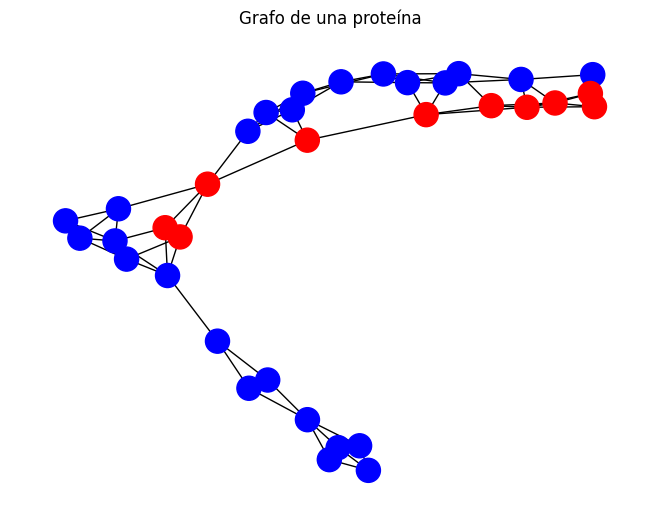

In [ ]:
root = '/data'
dataset = TUDataset(root=root, name='PROTEINS')

print(f'Dataset: {dataset}:')
print('====================')
print(f'Nº de grafos: {len(dataset)}')
print(f'Nº de características de un nodo: {dataset.num_features}')
print(f'Nº de clases: {dataset.num_classes}')


# COGEMOS UNA PROTEÍNA
data = dataset[813]
print('====================')
# Gather some statistics about the first graph.
print(f'Nº de nodos: {data.num_nodes}')
print(f'Nº de aristas: {data.num_edges}')
print(f'Media del grado de un nodo: {data.num_edges / data.num_nodes:.3f}')

# REPRESENTAMOS GRÁFICAMENTE
grafica_grafo(data)

# ANÁLISIS EXPLORATORIO DE LOS DATOS

A continuación se realiza un breve análisis de los datos para obtener cómo se distribuye la cantidad de nodos y de aristas junto con la proporción de proteínas que son enzimas. Esto nos ayudará a decidir qué hiperparámetros utilizar en el modelo y cómo se llevará a cabo el entrenamiento.

In [ ]:
num_nodos = []
num_aristas = []
clases = {}

for data in dataset:
    num_nodos.append(data.num_nodes)
    num_aristas.append(data.num_edges)

    clase = data.y.item()
    if clase in clases:
        clases[clase] += 1
    else:
        clases[clase] = 1

num_nodos = np.array(num_nodos)
num_aristas = np.array(num_aristas)
max_nodos = np.max(num_nodos)
min_nodos = np.min(num_nodos)
media_nodos = np.mean(num_nodos)
std_nodos = np.std(num_nodos)

max_aristas = np.max(num_aristas)
min_aristas = np.min(num_aristas)
media_aristas = np.mean(num_aristas)
std_aristas = np.std(num_aristas)

total_muestras = len(dataset)
proporciones_clases = {clase: count / total_muestras for clase, count in clases.items()}

print(f'Máximo número de nodos: {max_nodos:.3f}')
print(f'Mínimo número de nodos: {min_nodos:.3f}')
print(f'Media número de nodos: {media_nodos:.3f}')
print(f'Desviación típica número de nodos: {std_nodos:.3f}')
print('')
print('========================================')
print('')
print(f'Máximo número de aristas: {max_aristas:.3f}')
print(f'Mínimo número de aristas: {min_aristas:.3f}')
print(f'Media número de aristas: {media_aristas:.3f}')
print(f'Desviación típica número de aristas: {std_aristas:.3f}')
print('')
print('========================================')
print('')
print(f'Proporción de cada clase: No enzima -> {proporciones_clases[0]:.3f}, Enzima -> {proporciones_clases[1]:.3f}')

Máximo número de nodos: 620.000
Mínimo número de nodos: 4.000
Media número de nodos: 39.058
Desviación típica número de nodos: 45.758


Máximo número de aristas: 2098.000
Mínimo número de aristas: 10.000
Media número de aristas: 145.632
Desviación típica número de aristas: 169.198


Proporción de cada clase: No enzima -> 0.596, Enzima -> 0.404


# TRANSFORMACIONES PREVIAS

Vamos a incluir un nodo global artificial que se encargará de albergar toda la información resumida del grafo

In [ ]:
def add_global_node(dataset, tipo='Bidireccional'):
  result = []
  for data in dataset:
    node_features = np.array(data.x)
    global_node_feature = np.mean(node_features, axis=0)
    new_node_features = np.vstack((global_node_feature, node_features))
    new_node_features_tensor = torch.tensor(new_node_features, dtype=torch.float32)
    edge_index = np.array(data.edge_index)
    new_edge_index = edge_index+1
    if tipo=='Bidireccional':
      more_edges_source = list(range(1,data.num_nodes+1)) + [0]*data.num_nodes
      more_edges_target = [0]*data.num_nodes + list(range(1,data.num_nodes+1))
    else:
      more_edges_source = list(range(1,data.num_nodes+1))
      more_edges_target = [0]*data.num_nodes
    more_edges = np.array([more_edges_source, more_edges_target])
    new_edge_index = np.hstack((more_edges,new_edge_index))
    new_edge_index_tensor = torch.tensor(new_edge_index, dtype=torch.long)
    new_data = Data(x=new_node_features_tensor, edge_index=new_edge_index_tensor,y=data.y)
    result.append(new_data)
  return result

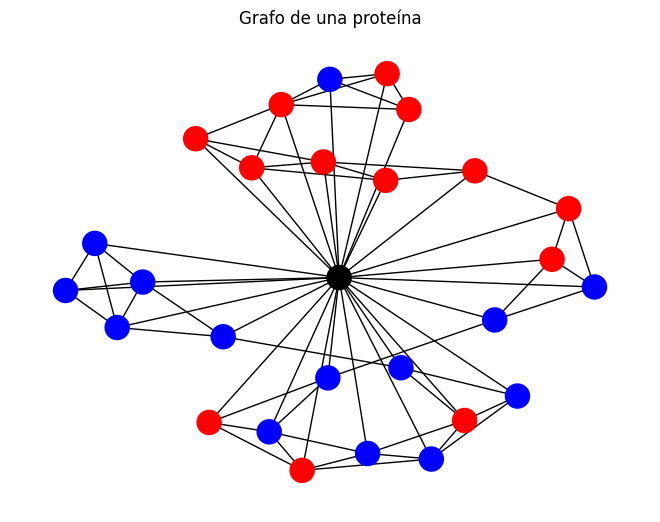

In [ ]:
add_gn = True
if add_gn:
  new_dataset = add_global_node(dataset)
else:
  new_dataset = list(dataset)

data = new_dataset[1]
grafica_grafo(data)

# PARTICIÓN EN ENTRENAMIENTO Y TEST

Vamos a dividir el conjunto de datos en 70% entrenamiento, 15% validación y 15% test. El conjunto de validación será usado tanto para el early stopping en la fase de entrenamiento como para comparar las diferentes propuestas de modelo.

In [ ]:
random.seed(12345)
random.shuffle(new_dataset)
pt = 0.7
pv = 0.15
Nt = int(pt*len(new_dataset))
Nv = int((pt+pv)*len(new_dataset))
train_dataset = new_dataset[0:Nt]
val_dataset = new_dataset[Nt:Nv]
test_dataset = new_dataset[Nv:]

print(f'Nº de grafos en entrenamiento: {len(train_dataset)}')
print(f'Nº de grafos en validación: {len(val_dataset)}')
print(f'Nº de grafos en test: {len(test_dataset)}')

Nº de grafos en entrenamiento: 779
Nº de grafos en validación: 167
Nº de grafos en test: 167


In [ ]:
train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=100, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=False)

# CONSTRUCCIÓN DE LOS MODELOS

In [ ]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GraphConv
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp
from torch_geometric.nn import TopKPooling

## MODELO 1

MODELO CON CAPAS CONVOLUCIONALES DE GRAFOS SIN USAR NODO GLOBAL Y HACIENDO GLOBAL MEAN y GLOBAL MAX PARA LA MLP.

In [ ]:
class Modelo1(torch.nn.Module):
    def __init__(self, hidden_channels=80):
        super(Modelo1, self).__init__()
        self.dropout_ratio = 0.4
        self.conv1 = GCNConv(3, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.lin1 = Linear(2*hidden_channels, hidden_channels)
        self.lin2 = Linear(hidden_channels, hidden_channels//2)
        self.lin3 = Linear(hidden_channels//2, 2)

    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)
        x1 = gap(x, batch)
        x2 = gmp(x, batch)
        x = torch.cat([x1, x2], dim=1)

        x = F.relu(self.lin1(x))
        x = F.dropout(x, p=self.dropout_ratio, training=self.training)
        x = F.relu(self.lin2(x))
        x = F.dropout(x, p=self.dropout_ratio, training=self.training)
        x = self.lin3(x)
        x = F.log_softmax(x, dim=-1)

        return x

## MODELO 2

MODELO CON CAPAS CONVOLUCIONALES DONDE EL NODO SE PROCESA CON DIFERENTES PARÁMETROS QUE SUS VECINOS, SIN NODO GLOBAL, EMPLEANDO TOPK POOLING PARA IR REDUCIENDO LA DIMENSIÓN DEL GRAFO DESPUÉS DE CADA CAPA. SE ALMACENAN LA MEDIA Y EL MÁXIMO DESPUÉS DE CADA CAPA PARA QUE SEAN LA ENTRADA DE LA MLP.

In [ ]:
class Modelo2(torch.nn.Module):
    def __init__(self, hidden_channels=80):
        super(Modelo2, self).__init__()
        self.dropout_ratio = 0.6
        self.conv1 = GraphConv(3, hidden_channels)
        self.conv2 = GraphConv(hidden_channels, hidden_channels)
        self.conv3 = GraphConv(hidden_channels, hidden_channels)
        self.pool1 = TopKPooling(hidden_channels, 0.5)
        self.pool2 = TopKPooling(hidden_channels, 0.5)
        self.lin1 = Linear(2*hidden_channels, hidden_channels)
        self.lin2 = Linear(hidden_channels, hidden_channels//2)
        self.lin3 = Linear(hidden_channels//2, 2)

    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x, edge_index, _, batch, _, _ = self.pool1(x, edge_index, None, batch)
        x1 = torch.cat([gmp(x, batch), gap(x, batch)], dim=1)

        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x, edge_index, _, batch, _, _ = self.pool2(x, edge_index, None, batch)
        x2 = torch.cat([gmp(x, batch), gap(x, batch)], dim=1)

        x = self.conv3(x, edge_index)
        x = F.relu(x)
        x3 = torch.cat([gmp(x, batch), gap(x, batch)], dim=1)

        x = F.relu(x1) + F.relu(x2) + F.relu(x3)

        x = F.relu(self.lin1(x))
        x = F.dropout(x, p=self.dropout_ratio, training=self.training)
        x = F.relu(self.lin2(x))
        x = F.dropout(x, p=self.dropout_ratio, training=self.training)
        x = self.lin3(x)
        x = F.log_softmax(x, dim=-1)

        return x

# MODELO 3

MODELO UTILIZANDO EL NODO GLOBAL ARTIFICIAL. EN LA MLP SE COGEN ÚNICAMENTE LAS CARACTERÍSTICAS DE ESTE NODO.

In [ ]:
class Modelo3(torch.nn.Module):
    def __init__(self, hidden_channels=80):
        super(Modelo3, self).__init__()
        self.dropout_ratio = 0.4
        self.conv1 = GraphConv(3, hidden_channels)
        self.conv2 = GraphConv(hidden_channels, hidden_channels)
        self.conv3 = GraphConv(hidden_channels, hidden_channels)
        self.lin1 = Linear(hidden_channels, hidden_channels)
        self.lin2 = Linear(hidden_channels, hidden_channels//2)
        self.lin3 = Linear(hidden_channels//2, 2)

    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)

        x = torch.stack([x[batch == B][0] for B in torch.unique(batch)], dim=0)

        x = F.relu(self.lin1(x))
        x = F.dropout(x, p=self.dropout_ratio, training=self.training)
        x = F.relu(self.lin2(x))
        x = F.dropout(x, p=self.dropout_ratio, training=self.training)
        x = self.lin3(x)
        x = F.log_softmax(x, dim=-1)

        return x

# ENTRENAMIENTO

Creamos el modelo.

In [ ]:
model = Modelo3()
print(model)
# CANTIDAD DE PARAMETROS
total_params = 0
for param in model.parameters():
  if param.requires_grad:
    total_params += param.numel()
print(f'Total de params: {total_params}')

Modelo3(
  (conv1): GraphConv(3, 80)
  (conv2): GraphConv(80, 80)
  (conv3): GraphConv(80, 80)
  (lin1): Linear(in_features=80, out_features=80, bias=True)
  (lin2): Linear(in_features=80, out_features=40, bias=True)
  (lin3): Linear(in_features=40, out_features=2, bias=True)
)
Total de params: 36122


Definimos el optimizador y el criterio de pérdida, y las funciones de entrenamiento y evaluación.

In [ ]:
optimizer = None

def train():
  model.train()
  for data in train_loader:
    optimizer.zero_grad()
    out = model(data.x, data.edge_index, data.batch)
    loss = F.nll_loss(out, data.y)
    loss.backward()
    optimizer.step()

def evaluate(loader, model):
  model.eval()
  total_error = 0
  total_aciertos = 0
  for data in loader:
    out = model(data.x, data.edge_index, data.batch)
    pred = out.argmax(dim=1)
    total_aciertos += int((pred == data.y).sum())
    batch_error = F.nll_loss(out, data.y).item()
    total_error += batch_error * data.num_graphs
  avg_error = total_error / len(loader.dataset)
  accuracy = total_aciertos/len(loader.dataset)
  return avg_error, accuracy

In [ ]:
val_accuracy_list = []
train_accuracy_list = []
test_accuracy_list = []
best_val_accuracy = 0
best_epoch = 0
EPOCHS = 200
patience = 30
counter = 0
best_model_weights = None
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(1,EPOCHS):
  train()

  train_error, train_accuracy = evaluate(train_loader, model)
  val_error, val_accuracy = evaluate(val_loader, model)
  test_error, test_accuracy = evaluate(test_loader, model)
  train_accuracy_list.append(train_accuracy)
  val_accuracy_list.append(val_accuracy)
  test_accuracy_list.append(test_accuracy)

  if val_accuracy > best_val_accuracy:
    counter = 0
    best_epoch = epoch
    best_val_accuracy = val_accuracy
    best_model_weights = model.state_dict()
    print(f'Mejor Val Accuracy: {best_val_accuracy}')
  else:
    print(f'Mejor Val Accuracy: {best_val_accuracy}')
    counter += 1
    if counter >= patience:
      print(f"Early stopping!: Epoch: {epoch:03d}, Train Accuracy: {train_accuracy:.3f}, Val Accuracy: {val_accuracy:.3f}, Best Val Accuracy: {best_val_accuracy:.3f}, Best Epoch: {best_epoch}")
      break

  print(f'Epoch: {epoch:03d}, Train Accuracy: {train_accuracy:.3f}, Val Accuracy: {val_accuracy:.3f}')


Mejor Val Accuracy: 0.6467065868263473
Epoch: 001, Train Accuracy: 0.582, Val Accuracy: 0.647
Mejor Val Accuracy: 0.6826347305389222
Epoch: 002, Train Accuracy: 0.625, Val Accuracy: 0.683
Mejor Val Accuracy: 0.6826347305389222
Epoch: 003, Train Accuracy: 0.625, Val Accuracy: 0.671
Mejor Val Accuracy: 0.6826347305389222
Epoch: 004, Train Accuracy: 0.570, Val Accuracy: 0.677
Mejor Val Accuracy: 0.6826347305389222
Epoch: 005, Train Accuracy: 0.589, Val Accuracy: 0.677
Mejor Val Accuracy: 0.6826347305389222
Epoch: 006, Train Accuracy: 0.638, Val Accuracy: 0.653
Mejor Val Accuracy: 0.6826347305389222
Epoch: 007, Train Accuracy: 0.582, Val Accuracy: 0.683
Mejor Val Accuracy: 0.7125748502994012
Epoch: 008, Train Accuracy: 0.616, Val Accuracy: 0.713
Mejor Val Accuracy: 0.7125748502994012
Epoch: 009, Train Accuracy: 0.666, Val Accuracy: 0.671
Mejor Val Accuracy: 0.7125748502994012
Epoch: 010, Train Accuracy: 0.661, Val Accuracy: 0.695
Mejor Val Accuracy: 0.7125748502994012
Epoch: 011, Train Acc

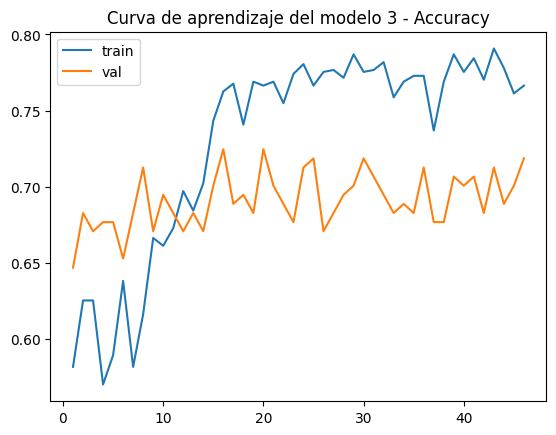

In [ ]:
accuracy_per_epoch = np.array([train_accuracy_list, val_accuracy_list])
plt.plot(range(1,len(train_accuracy_list)+1), train_accuracy_list, label='train')
plt.plot(range(1,len(val_accuracy_list)+1), val_accuracy_list, label='val')
plt.title('Curva de aprendizaje del modelo 3 - Accuracy')
plt.legend()
plt.show()

In [ ]:
# MODELO 2
model.load_state_dict(best_model_weights)
evaluate(test_loader, model)

(0.548111370580639, 0.7544910179640718)

# VISUALIZACIÓN DEL FUNCIONAMIENTO DEL MODELO EN LA PENÚLTIMA CAPA ANTES DE PREDECIR LAS PROBABILIDADES

Para ello modificamos ligeramente la salida del modelo para que nos devuelva la capa previa a la de salida. Lo que haremos será proyectar en dos dimensiones mediante PCA los patrones de entrenamiento evaluados hasta esa capa para cada época. Lo que se espera observar es que cuando el modelo no está entrenado los puntos se distribuyan de forma uniforme y a medida que avanza el entrenamiento tienden a separarse en dos clases.

In [ ]:
class Modelo2Mod(torch.nn.Module):
    def __init__(self, hidden_channels=80):
        super(Modelo2Mod, self).__init__()
        self.dropout_ratio = 0.4
        self.conv1 = GraphConv(3, hidden_channels)
        self.conv2 = GraphConv(hidden_channels, hidden_channels)
        self.conv3 = GraphConv(hidden_channels, hidden_channels)
        self.pool1 = TopKPooling(hidden_channels, 0.5)
        self.pool2 = TopKPooling(hidden_channels, 0.5)
        self.lin1 = Linear(2*hidden_channels, hidden_channels)
        self.lin2 = Linear(hidden_channels, hidden_channels//2)
        self.lin3 = Linear(hidden_channels//2, 2)

    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x, edge_index, _, batch, _, _ = self.pool1(x, edge_index, None, batch)
        x1 = torch.cat([gmp(x, batch), gap(x, batch)], dim=1)

        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x, edge_index, _, batch, _, _ = self.pool2(x, edge_index, None, batch)
        x2 = torch.cat([gmp(x, batch), gap(x, batch)], dim=1)

        x = self.conv3(x, edge_index)
        x = F.relu(x)
        x3 = torch.cat([gmp(x, batch), gap(x, batch)], dim=1)

        x = F.relu(x1) + F.relu(x2) + F.relu(x3)

        x = F.relu(self.lin1(x))
        x = F.dropout(x, p=self.dropout_ratio, training=self.training)
        x_pca = F.relu(self.lin2(x))
        x = F.dropout(x_pca, p=self.dropout_ratio, training=self.training)
        x = self.lin3(x)
        x = F.log_softmax(x, dim=-1)

        return x, x_pca

In [ ]:
def visualize_pca(epoch, vectors, y):
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(vectors)

    vectors_class1 = pca_result[y == 0]
    vectors_class2 = pca_result[y == 1]

    plt.scatter(vectors_class1[:, 0], vectors_class1[:, 1], c='b', label='No enzima', alpha=0.1)
    plt.scatter(vectors_class2[:, 0], vectors_class2[:, 1], c='r', label='Enzima', alpha=0.1)
    plt.title(f'PCA epoch {epoch}')
    plt.xlabel('Componente principal 1')
    plt.ylabel('Componente principal 2')
    plt.xlim(-10, 10)
    plt.ylim(-10, 10)
    plt.legend()

    plt.savefig(f'/content/gif_pca/{epoch}_pca.png')
    plt.close()

Creamos las imágenes por cada época de entrenamiento.

In [ ]:
if os.path.exists('gif_pca'):
    shutil.rmtree('gif_pca')
if not os.path.exists('gif_pca'):
    os.makedirs('gif_pca')

model = Modelo2Mod()
EPOCHS = 15
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# EPOCH 0 #
vectors_pca = []
y_pca = []
model.train()
for data in train_loader:
  out, out_pca = model(data.x, data.edge_index, data.batch)
  vectors_pca.append(out_pca)
  y_pca.append(data.y)
vectors_pca = torch.cat(vectors_pca, dim=0)
vectors_pca = vectors_pca.detach().numpy()
y_pca = torch.cat(y_pca, dim=0)
y_pca = np.array(y_pca)
visualize_pca(0, vectors_pca, y_pca)
##########

for epoch in range(1,EPOCHS):
  vectors_pca = []
  y_pca = []
  model.train()
  for data in train_loader:
    optimizer.zero_grad()
    out, out_pca = model(data.x, data.edge_index, data.batch)
    vectors_pca.append(out_pca)
    y_pca.append(data.y)
    loss = F.nll_loss(out, data.y)
    loss.backward()
    optimizer.step()
  vectors_pca = torch.cat(vectors_pca, dim=0)
  vectors_pca = vectors_pca.detach().numpy()
  y_pca = torch.cat(y_pca, dim=0)
  y_pca = np.array(y_pca)
  visualize_pca(epoch, vectors_pca, y_pca)
  print(f'Epoch: {epoch:03d}')

Epoch: 001
Epoch: 002
Epoch: 003
Epoch: 004
Epoch: 005
Epoch: 006
Epoch: 007
Epoch: 008
Epoch: 009
Epoch: 010
Epoch: 011
Epoch: 012
Epoch: 013
Epoch: 014


Por último, creamos el vídeo.

In [ ]:
carpeta_imagenes = '/content/gif_pca'

lista_imagenes = sorted(os.listdir(carpeta_imagenes), key=lambda x: int(x.split('_')[0]))

imagen = cv2.imread(os.path.join(carpeta_imagenes, lista_imagenes[0]))
alto, ancho, _ = imagen.shape

nombre_video = 'video_pca.mp4'
fps = 1

video = cv2.VideoWriter(nombre_video, cv2.VideoWriter_fourcc(*'DIVX'), fps, (ancho, alto))
for nombre_imagen in lista_imagenes:
    ruta_imagen = os.path.join(carpeta_imagenes, nombre_imagen)
    imagen = cv2.imread(ruta_imagen)
    video.write(imagen)

video.release()